<a href="https://colab.research.google.com/github/abhinav70291/TechnicalAnalysis-for-intra-day-trading/blob/main/Technical_Analysis_correlation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade ipywidgets matplotlib
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectMultiple, SelectionRangeSlider
from datetime import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.5 MB/s eta 0:00:00


In [2]:
df=pd.read_csv("/content/Manappuram_10minute.csv")
df.tail(5)

,Date,Open,High,Low,Close,Volume
2492,2020-04-28T14:35:00,123.90,124.25,123.7,124.15,289726
2493,2020-04-28T14:45:00,124.15,125.80,124.1,125.80,1706683
2494,2020-04-28T14:55:00,125.80,125.80,125.8,125.80,145240
2495,2020-04-28T15:05:00,125.80,131.50,125.8,130.85,3162404
2496,2020-04-28T15:15:00,130.95,130.95,129.6,129.75,221556


In [3]:
# Converting Date column into datetime dftype
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


# **State the Values you want to consider for this backtesting and technical analysis**

In [4]:
# Initialize a DataFrame to store metrics for each parameter
metrics_df = pd.DataFrame(columns=['indicator', 'hit_rate', 'profit_factor', 'sharpe_ratio', 'max_drawdown', 'total_profit', 'profit_percentage', 'avg_win_to_avg_loss_ratio', 'sortino_ratio', 'num_trades'])

# **Defining ALL indicator functions  here**

In [5]:
# calculates SMA using "n" as the rolling window size
def ma_calc(df, n):
  df["sma"] = df.Close.rolling(window=n).mean()
  return df

# calculates SMA using "m" and "n" as the rolling window size
def longshort_ma_calc(df, m, n):
  df["sma_short"] = df.Close.rolling(window=min(m,n)).mean()
  df["sma_long"] = df.Close.rolling(window=max(m,n)).mean()
  return df

# calculates EMA using "n" as the rolling window size
def ema_calc(df, n):
  df["ema"] = df.Close.ewm(span=n, adjust=False).mean()
  return df


def longshort_ema_calc(df, m, n):
  df["ema_short"] = df.Close.ewm(span=min(m,n), adjust=False).mean()
  df["ema_long"] = df.Close.ewm(span=max(m,n), adjust=False).mean()
  return df

# calculates RSI using "n" as the lookback period
def rsi_calc(df, n):
  df['rsi'] = 100 - (100 / (1 + df['Close'].diff().apply(lambda x: x if x > 0 else 0).rolling(window=n).mean() / df['Close'].diff().apply(lambda x: -x if x < 0 else 0).rolling(window=n).mean()))
  return df

# calculates OBV
def obv_calc(df):
  df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
  return df

def bb_calc(df, n):
  df["sma"] = df.Close.rolling(window=n).mean()
  df["std"] = df.Close.rolling(window=n).std()
  df["upper_bb"] = df["sma"] + (2 * df["std"])
  df["lower_bb"] = df["sma"] - (2 * df["std"])
  return df

# Volume weighted average price
def vwap_calc(df):
    df['vwap'] = (df['Volume'] * df['Close']).cumsum() / df['Volume'].cumsum()
    return df

# Supertrend Indicator
def supertrend_calc(df, period, multiplier):
    # Calculate basic upper and lower bands
    df['hl_avg'] = (df['High'] + df['Low']) / 2
    df['range'] = df['High'] - df['Low']
    df['upper_band'] = df['hl_avg'] + multiplier * df['range']
    df['lower_band'] = df['hl_avg'] - multiplier * df['range']

    # Calculate final upper and lower bands
    df['upper_band_final'] = np.where((df['upper_band'] < df['upper_band'].shift(1)) | (df['Close'] > df['upper_band'].shift(1)), df['upper_band'], df['upper_band'].shift(1))
    df['lower_band_final'] = np.where((df['lower_band'] > df['lower_band'].shift(1)) | (df['Close'] < df['lower_band'].shift(1)), df['lower_band'], df['lower_band'].shift(1))

    # Calculate Supertrend
    df['supertrend'] = np.where(df['Close'] <= df['upper_band_final'], df['upper_band_final'], df['lower_band_final'])
    df['supertrend'] = np.where(df['Close'] >= df['lower_band_final'], df['lower_band_final'], df['supertrend'])

    return df

# calculates Average Directional Index (ADX)
def adx_calc(df, n):
    df['hl_diff'] = df['High'] - df['Low']
    df['hc_diff'] = abs(df['High'] - df['Close'].shift(1))
    df['lc_diff'] = abs(df['Low'] - df['Close'].shift(1))
    df['tr'] = df[['hl_diff', 'hc_diff', 'lc_diff']].max(axis=1)
    df['+dm'] = np.where((df['High'] > df['High'].shift(1)) & (df['High'] - df['High'].shift(1) > df['Low'].shift(1) - df['Low']), df['High'] - df['High'].shift(1), 0)
    df['-dm'] = np.where((df['Low'] < df['Low'].shift(1)) & (df['High'].shift(1) - df['High'] < df['Low'].shift(1) - df['Low']), df['Low'].shift(1) - df['Low'], 0)
    df['tr_ema'] = df['tr'].ewm(span=n, adjust=False).mean()
    df['+dm_ema'] = df['+dm'].ewm(span=n, adjust=False).mean()
    df['-dm_ema'] = df['-dm'].ewm(span=n, adjust=False).mean()
    df['+di'] = (df['+dm_ema'] / df['tr_ema']) * 100
    df['-di'] = (df['-dm_ema'] / df['tr_ema']) * 100
    df['dx'] = (abs(df['+di'] - df['-di']) / (df['+di'] + df['-di'])) * 100
    df['adx'] = df['dx'].rolling(window=n).mean()

    return df

# calculates MACD
def macd_calc(df, short_n, long_n, signal_n):
    df['ema_short'] = df['Close'].ewm(span=short_n, adjust=False).mean()
    df['ema_long'] = df['Close'].ewm(span=long_n, adjust=False).mean()
    df['macd_line'] = df['ema_short'] - df['ema_long']
    df['signal_line'] = df['macd_line'].ewm(span=signal_n, adjust=False).mean()
    df['macd_histogram'] = df['macd_line'] - df['signal_line']

    return df


# **Backtesting starts from here**
**Our Indicators for consideration here are -**

(i) Inflection Points

(ii)  SMA

(iii) Short term SMA and Long term SMA

(iv) EMA

(v) Short term EMA and Long term EMA

(vi) RSI

(vii) Average Directional Index

(viii)  Bollinger Bands



In [6]:
# Run the loop and find the optimal parameters
starting_capital = 10000  # Starting capital in your currency
stop_loss = 0.05  # Stop loss level (5% in this case)
upper_cap = 8000  # Upper investment cap in your currency
lower_cap = 1000  # Lower investment cap in your currency
transaction_cost = 0.001  # Transaction cost (0.1% in this case)
leverage = 1 # Leverage (1x in this case meaning no leverage, just the original capital)
volume_percentage = 0.001  # Minimum average daily volume
trade_type="intraday"

**Inflection points Window optimization**

In [7]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

def find_extrema(df, n):
    df['min'] = df.iloc[argrelextrema(df['Close'].values, np.less_equal, order=n)[0]]['Close']
    df['max'] = df.iloc[argrelextrema(df['Close'].values, np.greater_equal, order=n)[0]]['Close']
    return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type):
    df = find_extrema(df, n)
    df['true_signal'] = 0  # Initialize the signal column
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits=[]

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            if not in_position and not np.isnan(row['min']):
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'true_signal'] = 1  # Indicate a buy decision

            if in_position and (not np.isnan(row['max']) and row.Close < buyprice * (1 - stop_loss)):
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'true_signal'] = -1  # Indicate a sell decision
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)


                # If still in position at the end of the day, sell
            if trade_type=="intraday":
                if in_position and index == df_day.index[-1]:
                    sell_proceeds = row.Close * shares_to_trade
                    profit = sell_proceeds - investment
                    profits.append(profit)
                    capital += sell_proceeds * (1 - transaction_cost)
                    in_position = False
                    num_trades += 1
                    df.loc[index, 'true_signal'] = -1  # Indicate a sell decision
                    if profit > 0:
                        wins.append(profit)
                    else:
                        losses.append(profit)

        daily_profits.append(sum(profits))

    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio =  daily_profits.mean() / daily_profits.std()
    sortino_ratio = daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.abs(np.mean(wins) / np.mean(losses))

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

metrics_dict_extrema = {}

for n in range(1, 38*30):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_extrema[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_extrema, key=lambda x: metrics_dict_extrema[x][2])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)

# Run the backtest function with the best n to get the signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)

# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"Local Extrema",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)


For parameter: 1, Hit Rate: 0.5151515151515151, Profit Factor: 1.955600570315761, Sharpe Ratio: 0.20104232725900878, Max Drawdown: -968.9999999999991, Total Profit: 4411.815050000056, Profit Percentage: 44.11815050000056%, Average Win to Average Loss ratio: 1.836024791190608, Sortino Ratio: 0.3545768358379557, Number of Trades: 68
For parameter: 2, Hit Rate: 0.5454545454545454, Profit Factor: 2.089990647397023, Sharpe Ratio: 0.21653696362206293, Max Drawdown: -961.4499999999998, Total Profit: 4471.191810500062, Profit Percentage: 44.71191810500063%, Average Win to Average Loss ratio: 1.7997141685918807, Sortino Ratio: 0.3995361560267573, Number of Trades: 67
For parameter: 3, Hit Rate: 0.5909090909090909, Profit Factor: 2.5507797407071213, Sharpe Ratio: 0.2643268867485154, Max Drawdown: -961.4499999999998, Total Profit: 5596.836541400058, Profit Percentage: 55.96836541400059%, Average Win to Average Loss ratio: 1.8313290446102406, Sortino Ratio: 0.4431134534232571, Number of Trades: 67

In [8]:
 # Initialize the signal column with hold signals
df['true_signal'] = 0

# Generate buy signals at local minima
df.loc[df['min'].notna(), 'true_signal'] = 1

# Generate sell signals at local maxima
df.loc[df['max'].notna(), 'true_signal'] = -1

df.head(20)

,Open,High,Low,Close,Volume,min,max,true_signal
Date,,,,,,,,
2020-01-21 09:15:00,179.30,180.20,178.25,180.15,173897,NaN,NaN,0
2020-01-21 09:25:00,180.00,181.30,180.00,180.50,175277,NaN,NaN,0
2020-01-21 09:35:00,180.50,181.05,180.25,180.55,110920,NaN,NaN,0
2020-01-21 09:45:00,180.55,181.50,180.05,181.35,80456,NaN,181.35,-1
2020-01-21 09:55:00,181.35,181.65,181.00,181.30,73996,NaN,NaN,0
2020-01-21 10:05:00,181.30,181.50,180.35,180.60,32035,NaN,NaN,0
2020-01-21 10:15:00,180.60,180.70,180.15,180.30,40860,NaN,NaN,0
2020-01-21 10:25:00,180.30,180.30,179.70,179.70,57684,179.7,NaN,1
2020-01-21 10:35:00,179.70,180.10,178.90,179.90,113474,NaN,NaN,0


**SMA Optimization**

In [9]:
import numpy as np
import pandas as pd

def ma_calc(df, n):
    df['sma'] = df['Close'].rolling(n).mean()
    return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type):
    df = ma_calc(df, n)
    df['sma_signal'] = 0  # Initialize the signal column
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits=[]

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            # describe strategy
            if not in_position and row.Close > row.sma:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'sma_signal'] = 1  # Indicate a buy decision

            if in_position and (row.Close < row.sma and row.Close < buyprice * (1 - stop_loss)) :
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'sma_signal'] = -1  # Indicate a sell decision
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

            if trade_type=="intraday":
                if in_position and index == df_day.index[-1]:
                    sell_proceeds = row.Close * shares_to_trade
                    profit = sell_proceeds - investment
                    profits.append(profit)
                    capital += sell_proceeds * (1 - transaction_cost)
                    in_position = False
                    num_trades += 1
                    df.loc[index, 'sma_signal'] = -1  # Indicate a sell decision
                    if profit > 0:
                        wins.append(profit)
                    else:
                        losses.append(profit)

        daily_profits.append(sum(profits))



    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio =  daily_profits.mean() / daily_profits.std()
    sortino_ratio = daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.abs(np.mean(wins) / np.mean(losses))

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

metrics_dict_sma = {}

for n in range(304, 570,5):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_sma[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_sma, key=lambda x: metrics_dict_sma[x][2])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)
# Run the backtest function with the best n to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades =backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"SMA",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)



For parameter: 304, Hit Rate: 0.22727272727272727, Profit Factor: 1.4263239931851956, Sharpe Ratio: 0.09013477844600941, Max Drawdown: -490.0000000000009, Total Profit: 682.9377000000204, Profit Percentage: 6.829377000000204%, Average Win to Average Loss ratio: 1.333560831926434, Sortino Ratio: 0.11181869628818342, Number of Trades: 31
For parameter: 309, Hit Rate: 0.22727272727272727, Profit Factor: 1.4295108172421933, Sharpe Ratio: 0.09063544358245727, Max Drawdown: -490.0000000000009, Total Profit: 704.7230500000187, Profit Percentage: 7.047230500000187%, Average Win to Average Loss ratio: 1.247412474124741, Sortino Ratio: 0.11218595650795617, Number of Trades: 30
For parameter: 314, Hit Rate: 0.22727272727272727, Profit Factor: 1.5391054350589664, Sharpe Ratio: 0.10952957497215686, Max Drawdown: -402.5499999999993, Total Profit: 932.41885000002, Profit Percentage: 9.3241885000002%, Average Win to Average Loss ratio: 1.333891377051104, Sortino Ratio: 0.15513726471004824, Number of T

**Long term and Short term SMA**

In [10]:
import numpy as np
import pandas as pd

def longshort_ma_calc(df, m, n):
    df['sma_short'] = df['Close'].rolling(m).mean()
    df['sma_long'] = df['Close'].rolling(n).mean()
    return df

volume_threshold = 1.5 * df['Volume'].mean()

def backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type):
    df['sma_crossover_signal'] = 0
    df = longshort_ma_calc(df, m, n)
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits=[]

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            if not in_position and row.sma_short > row.sma_long:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'sma_crossover_signal'] = 1

            if in_position and (row.sma_short < row.sma_long and row.Close < buyprice * (1 - stop_loss)):
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'sma_crossover_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

            # If still in position at the end of the day, sell
            if trade_type=="intraday":
                if in_position and index == df_day.index[-1]:
                    sell_proceeds = row.Close * shares_to_trade
                    profit = sell_proceeds - investment
                    profits.append(profit)
                    capital += sell_proceeds * (1 - transaction_cost)
                    in_position = False
                    num_trades += 1
                    df.loc[index, 'sma_crossover_signal'] = -1  # Indicate a sell decision
                    if profit > 0:
                        wins.append(profit)
                    else:
                        losses.append(profit)


        daily_profits.append(sum(profits))

    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio =  daily_profits.mean() / daily_profits.std()
    sortino_ratio = daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

metrics_dict_ls_sma = {}

for m in range(2, 19):
    for n in range(38*8, 38*20+1,10):
        df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
        print(f"For parameter: ({m},{n}), Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
        metrics_dict_ls_sma[(m, n)] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best (m, n)
best_m_n = max(metrics_dict_ls_sma, key=lambda x: metrics_dict_ls_sma[x][2])  # This line finds the (m, n) that gives the maximum Sharpe Ratio
print("The best parameters are ", best_m_n)

# Run the backtest function with the best (m, n) to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, best_m_n[0], best_m_n[1], starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)

metrics_df = metrics_df.append({
    "Indicator":"SMA_Crossover",
    'Best_n': best_m_n[1],  # best_n is now the second element of best_m_n
    'Best_m': best_m_n[0],  # best_m is now the first element of best_m_n
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)


For parameter: (2,304), Hit Rate: 0.22727272727272727, Profit Factor: 1.4072285603700911, Sharpe Ratio: 0.08880523086849136, Max Drawdown: -402.5499999999993, Total Profit: 627.8246500000241, Profit Percentage: 6.278246500000241%, Average Win to Average Loss ratio: -1.4072285603700911, Sortino Ratio: 0.1291173802899834, Number of Trades: 30
For parameter: (2,314), Hit Rate: 0.22727272727272727, Profit Factor: 1.5062252927919606, Sharpe Ratio: 0.10611352354808931, Max Drawdown: -402.5499999999993, Total Profit: 908.758200000022, Profit Percentage: 9.08758200000022%, Average Win to Average Loss ratio: -1.4058102732724964, Sortino Ratio: 0.1597925348107964, Number of Trades: 29
For parameter: (2,324), Hit Rate: 0.24242424242424243, Profit Factor: 1.8150470219435735, Sharpe Ratio: 0.14879887702388409, Max Drawdown: -384.8000000000002, Total Profit: 1383.7676000000247, Profit Percentage: 13.837676000000245%, Average Win to Average Loss ratio: -1.4747257053291534, Sortino Ratio: 0.2291466770

**EMA**

In [11]:
import numpy as np
import pandas as pd

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type):
    df = ema_calc(df, n)
    df['ema_signal'] = 0  # Initialize the signal column
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits=[]

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            if not in_position and row.Close > row.ema:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'ema_signal'] = 1  # Indicate a buy decision

            if in_position and (row.Close < row.ema and row.Close < buyprice * (1 - stop_loss)) :
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'ema_signal'] = -1  # Indicate a sell decision
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

            # If still in position at the end of the day, sell
            if trade_type=="intraday":
                if in_position and index == df_day.index[-1]:
                    sell_proceeds = row.Close * shares_to_trade
                    profit = sell_proceeds - investment
                    profits.append(profit)
                    capital += sell_proceeds * (1 - transaction_cost)
                    in_position = False
                    num_trades += 1
                    df.loc[index, 'ema_signal'] = -1  # Indicate a sell decision
                    if profit > 0:
                        wins.append(profit)
                    else:
                        losses.append(profit)

        daily_profits.append(sum(profits))



    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio =  daily_profits.mean() / daily_profits.std()
    sortino_ratio = daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.abs(np.mean(wins) / np.mean(losses))

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

metrics_dict_ema = {}

for n in range(38, 570,5):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_ema[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_ema, key=lambda x: metrics_dict_ema[x][2])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)
# Run the backtest function with the best n to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades =backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"EMA",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)



For parameter: 38, Hit Rate: 0.36363636363636365, Profit Factor: 1.621555793357823, Sharpe Ratio: 0.12779443108707667, Max Drawdown: -959.800000000002, Total Profit: 1896.9230534500566, Profit Percentage: 18.969230534500568%, Average Win to Average Loss ratio: 1.724086887717055, Sortino Ratio: 0.1973032217056314, Number of Trades: 54
For parameter: 43, Hit Rate: 0.3484848484848485, Profit Factor: 1.669897078919776, Sharpe Ratio: 0.13478151338538716, Max Drawdown: -494.9499999999998, Total Profit: 1950.5084738500482, Profit Percentage: 19.505084738500482%, Average Win to Average Loss ratio: 1.7160979498999713, Sortino Ratio: 0.26057739425408827, Number of Trades: 53
For parameter: 48, Hit Rate: 0.3484848484848485, Profit Factor: 1.994305353939319, Sharpe Ratio: 0.1694457320347428, Max Drawdown: -494.9499999999998, Total Profit: 2590.459483850056, Profit Percentage: 25.90459483850056%, Average Win to Average Loss ratio: 1.9625957466976158, Sortino Ratio: 0.34393067335583577, Number of Tr

**Long short EMA**

In [12]:
import numpy as np
import pandas as pd


def backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type):
    df['ema_crossover_signal'] = 0
    df = longshort_ema_calc(df, m, n)
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits=[]

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            if not in_position and row.ema_short > row.ema_long:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'ema_crossover_signal'] = 1

            if in_position and (row.ema_short < row.ema_long and row.Close < buyprice * (1 - stop_loss)):
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'ema_crossover_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)


            # If still in position at the end of the day, sell
            if trade_type=="intraday":
                if in_position and index == df_day.index[-1]:
                    sell_proceeds = row.Close * shares_to_trade
                    profit = sell_proceeds - investment
                    profits.append(profit)
                    capital += sell_proceeds * (1 - transaction_cost)
                    in_position = False
                    num_trades += 1
                    df.loc[index, 'ema_crossover_signal'] = -1  # Indicate a sell decision
                    if profit > 0:
                        wins.append(profit)
                    else:
                        losses.append(profit)


        daily_profits.append(sum(profits))

    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio =  daily_profits.mean() / daily_profits.std()
    sortino_ratio = daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

metrics_dict_ls_ema = {}

for m in range(5, 38):
    for n in range(38*8, 38*20+1,10):
        df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
        print(f"For parameter: ({m},{n}), Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
        metrics_dict_ls_ema[(m, n)] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best (m, n)
best_m_n = max(metrics_dict_ls_ema, key=lambda x: metrics_dict_ls_ema[x][4])  # This line finds the (m, n) that gives the maximum Sharpe Ratio
print("The best parameters are ", best_m_n)

# Run the backtest function with the best (m, n) to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, best_m_n[0], best_m_n[1], starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)

metrics_df = metrics_df.append({
    "Indicator":"EMA_Crossover",
    'Best_n': best_m_n[1],  # best_n is now the second element of best_m_n
    'Best_m': best_m_n[0],  # best_m is now the first element of best_m_n
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)


For parameter: (5,304), Hit Rate: 0.2727272727272727, Profit Factor: 1.3796895563287617, Sharpe Ratio: 0.08640629955605642, Max Drawdown: -492.0, Total Profit: 513.0861500000319, Profit Percentage: 5.13086150000032%, Average Win to Average Loss ratio: -1.226390716736677, Sortino Ratio: 0.11441591031101674, Number of Trades: 34
For parameter: (5,314), Hit Rate: 0.25757575757575757, Profit Factor: 1.3960729262278866, Sharpe Ratio: 0.08981777809569837, Max Drawdown: -492.0, Total Profit: 560.220650000032, Profit Percentage: 5.60220650000032%, Average Win to Average Loss ratio: -1.3960729262278866, Sortino Ratio: 0.11817305948786028, Number of Trades: 34
For parameter: (5,324), Hit Rate: 0.25757575757575757, Profit Factor: 1.3864203963562547, Sharpe Ratio: 0.08758040445850877, Max Drawdown: -492.0, Total Profit: 534.9925500000354, Profit Percentage: 5.349925500000354%, Average Win to Average Loss ratio: -1.3864203963562547, Sortino Ratio: 0.11575584815263638, Number of Trades: 34
For param

**RSI**

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type):
  df = rsi_calc(df, n)
  df['rsi_signal'] = 0
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
        volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
        if not in_position:
            if row.rsi < 30 and row.Volume > volume_limit:  # RSI is less than 30, oversold condition
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'rsi_signal'] = 1

        if in_position:
            if row.rsi > 70 or row.Close < buyprice * (1 - stop_loss):  # RSI is greater than 70, overbought condition
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'rsi_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)
    # If still in position at the end of the day, sell
        # If still in position at the end of the day, sell
            if trade_type=="intraday":
                if in_position and index == df_day.index[-1]:
                    sell_proceeds = row.Close * shares_to_trade
                    profit = sell_proceeds - investment
                    profits.append(profit)
                    capital += sell_proceeds * (1 - transaction_cost)
                    in_position = False
                    num_trades += 1
                    df.loc[index, 'rsi_signal'] = -1  # Indicate a sell decision
                    if profit > 0:
                        wins.append(profit)
                    else:
                        losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio =  daily_profits.mean() / daily_profits.std()
  sortino_ratio =  daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return df,hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Initialize a dictionary to store metrics for each parameter
metrics_dict_rsi = {}

for n in range(38,38*10,5):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_rsi[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_rsi, key=lambda x: metrics_dict_rsi[x][2])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)
# Run the backtest function with the best n to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades =backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"RSI",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)



For parameter: 38, Hit Rate: 0.07575757575757576, Profit Factor: 0.9982990593798364, Sharpe Ratio: -0.0002700842875229188, Max Drawdown: -1457.9999999999982, Total Profit: -290.7967999999855, Profit Percentage: -2.9079679999998556%, Average Win to Average Loss ratio: -1.5688594923966932, Sortino Ratio: -0.00017001949858422958, Number of Trades: 18
For parameter: 43, Hit Rate: 0.07575757575757576, Profit Factor: 0.9415812567801688, Sharpe Ratio: -0.009492192283144294, Max Drawdown: -1426.4999999999982, Total Profit: -450.13839999998527, Profit Percentage: -4.501383999999852%, Average Win to Average Loss ratio: -1.3483653112988814, Sortino Ratio: -0.005430055786565524, Number of Trades: 17
For parameter: 48, Hit Rate: 0.07575757575757576, Profit Factor: 1.078382614146903, Sharpe Ratio: 0.010700930945621814, Max Drawdown: -1426.4999999999982, Total Profit: -66.9622499999823, Profit Percentage: -0.669622499999823%, Average Win to Average Loss ratio: -1.3817823776987948, Sortino Ratio: 0.00

**Bollinger Bands**

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type):
  df = bb_calc(df, n)
  df['bb_signal'] = 0
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.Close > row.upper_bb and row.Volume > volume_limit:  # Price is above lower Bollinger Band
            buyprice = row.Close
            shares_to_trade = min(volume_limit, upper_cap // buyprice)
            investment = buyprice * shares_to_trade

            if investment > capital * leverage:
                continue

            capital -= investment * (1 + transaction_cost)
            in_position = True
            df.loc[index, 'bb_signal'] = 1

      if in_position:
        if row.Close < row.lower_bb and row.Close < buyprice * (1 - stop_loss):  # Price is above upper Bollinger Band or stop loss is hit
            sell_proceeds = row.Close * shares_to_trade
            profit = sell_proceeds - investment
            profits.append(profit)
            capital += sell_proceeds * (1 - transaction_cost)
            in_position = False
            num_trades += 1
            df.loc[index, 'bb_signal'] = -1
            if profit > 0:
                wins.append(profit)
            else:
                losses.append(profit)
        # If still in position at the end of the day, sell
            if trade_type=="intraday":
                if in_position and index == df_day.index[-1]:
                    sell_proceeds = row.Close * shares_to_trade
                    profit = sell_proceeds - investment
                    profits.append(profit)
                    capital += sell_proceeds * (1 - transaction_cost)
                    in_position = False
                    num_trades += 1
                    df.loc[index, 'bb_signal'] = -1  # Indicate a sell decision
                    if profit > 0:
                        wins.append(profit)
                    else:
                        losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio =  daily_profits.mean() / daily_profits.std()
  sortino_ratio = daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return df,hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Initialize a dictionary to store metrics for each parameter
metrics_dict_bb = {}
for n in range(2, 38*10,5):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_bb[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_bb, key=lambda x: metrics_dict_bb[x][4])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)
# Run the backtest function with the best n to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades =backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"Bollinger Bands",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)


For parameter: 2, Hit Rate: 0.0, Profit Factor: nan, Sharpe Ratio: nan, Max Drawdown: 0, Total Profit: 0, Profit Percentage: 0.0%, Average Win to Average Loss ratio: nan, Sortino Ratio: nan, Number of Trades: 0
For parameter: 7, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -0.2470152568687434, Max Drawdown: -716.75, Total Profit: -2392.730899999995, Profit Percentage: -23.927308999999948%, Average Win to Average Loss ratio: nan, Sortino Ratio: -0.2663591420608538, Number of Trades: 4
For parameter: 12, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -0.2811208827487328, Max Drawdown: -582.5, Total Profit: -2362.5820499999927, Profit Percentage: -23.62582049999993%, Average Win to Average Loss ratio: nan, Sortino Ratio: -0.4810779132681606, Number of Trades: 5
For parameter: 17, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -0.28351495637653, Max Drawdown: -473.0, Total Profit: -9403.8513493, Profit Percentage: -94.03851349299998%, Average Win to Average Loss ratio: nan, Sortino

**ADX**

In [15]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def adx_calc(df, n):
    df['hl_diff'] = df['High'] - df['Low']
    df['hc_diff'] = abs(df['High'] - df['Close'].shift(1))
    df['lc_diff'] = abs(df['Low'] - df['Close'].shift(1))
    df['tr'] = df[['hl_diff', 'hc_diff', 'lc_diff']].max(axis=1)
    df['+dm'] = np.where((df['High'] > df['High'].shift(1)) & (df['High'] - df['High'].shift(1) > df['Low'].shift(1) - df['Low']), df['High'] - df['High'].shift(1), 0)
    df['-dm'] = np.where((df['Low'] < df['Low'].shift(1)) & (df['High'].shift(1) - df['High'] < df['Low'].shift(1) - df['Low']), df['Low'].shift(1) - df['Low'], 0)
    df['tr_ema'] = df['tr'].ewm(span=n, adjust=False).mean()
    df['+dm_ema'] = df['+dm'].ewm(span=n, adjust=False).mean()
    df['-dm_ema'] = df['-dm'].ewm(span=n, adjust=False).mean()
    df['+di'] = (df['+dm_ema'] / df['tr_ema']) * 100
    df['-di'] = (df['-dm_ema'] / df['tr_ema']) * 100
    df['dx'] = (abs(df['+di'] - df['-di']) / (df['+di'] + df['-di'])) * 100
    df['adx'] = df['dx'].rolling(window=n).mean()

    return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type):
  df = adx_calc(df, n)
  df['adx_signal'] = 0
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
        volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
        if not in_position:
            if row['+di'] > row['-di'] and row.adx > 25 and row.Volume > volume_limit:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'adx_signal'] = 1

        if in_position:
            if row['+di'] < row['-di'] or row.Close < buyprice * (1 - stop_loss):
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'adx_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)
        # If still in position at the end of the day, sell
            if trade_type=="intraday":
                if in_position and index == df_day.index[-1]:
                    sell_proceeds = row.Close * shares_to_trade
                    profit = sell_proceeds - investment
                    profits.append(profit)
                    capital += sell_proceeds * (1 - transaction_cost)
                    in_position = False
                    num_trades += 1
                    df.loc[index, 'adx_signal'] = -1  # Indicate a sell decision
                    if profit > 0:
                        wins.append(profit)
                    else:
                        losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio =  daily_profits.mean() / daily_profits.std()
  sortino_ratio = daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades


# Initialize a dictionary to store metrics for each parameter
metrics_dict_adx = {}

for n in range(2, 38*10,5):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_adx[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_adx, key=lambda x: metrics_dict_adx[x][2])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)
# Run the backtest function with the best n to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades =backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage,trade_type)
# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"ADX ",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)


For parameter: 2, Hit Rate: 0.10606060606060606, Profit Factor: 0.46376577383217726, Sharpe Ratio: -0.1968532849571313, Max Drawdown: -256.65000000000055, Total Profit: -2873.1229677498986, Profit Percentage: -28.731229677498987%, Average Win to Average Loss ratio: -1.830340723402786, Sortino Ratio: -0.22036223436179975, Number of Trades: 126
For parameter: 7, Hit Rate: 0.16666666666666666, Profit Factor: 0.37513003615939694, Sharpe Ratio: -0.28086254660705107, Max Drawdown: -229.59999999999854, Total Profit: -2847.467267499919, Profit Percentage: -28.47467267499919%, Average Win to Average Loss ratio: -1.7224147217794643, Sortino Ratio: -0.32904475826396906, Number of Trades: 104
For parameter: 12, Hit Rate: 0.19696969696969696, Profit Factor: 0.9012204294188669, Sharpe Ratio: -0.02633517621808393, Max Drawdown: -242.59999999999854, Total Profit: -1288.2762557499336, Profit Percentage: -12.882762557499335%, Average Win to Average Loss ratio: -2.1211105183178947, Sortino Ratio: -0.0522

# **Deterministic Methods using Multiple indicators**

**I'd be using four methods to combine multiple indicators and make a decision-**

1) use a maxvote method per row( highest occurences among 1,0 and -1)

2)use a maxvote method per row, but diacard the 0, such that a decision is made even if it has the slightest chance

3)use a sliding window of length n(optimized) , which will use a max vote strategy , taking in all the indicator values across a window of n (if there are 5 inidcator signals, nd a window of 3, maxvote would be calculated using 5x3=15 values)

4) using consecutive values for maxvote - if let's say some maxvote signal occurs consecutively twice or thrice or n number of times, we will make a decision

**MAXVOTE**

In [59]:
dataframe=df.copy()
target_column=dataframe[["true_signal"]]
dataframe=dataframe[["sma_signal","ema_signal","rsi_signal","bb_signal","adx_signal"]]
dataframe.reset_index(drop=True,inplace=True)


def maxvote(row_values):
    unique, counts = np.unique(row_values, return_counts=True)
    max_vote = unique[np.argmax(counts)]
    return max_vote  # return the result, not the function

dataframe["max_vote"] = [0] * len(dataframe)

for i in range(len(dataframe)):
    row_values = dataframe.loc[i,:]
    dataframe.loc[i, "max_vote"] = maxvote(row_values)


**MAXVOTE, but comparing the votes only for 1 and -1 and not 0**

In [60]:
# Define the maxvote function
def max_vote_without_0(row_values):
    # Filter out zeros
    non_zero_values = row_values[row_values != 0]
    if len(non_zero_values) == 0:  # If all values are zero, return zero
        return 0
    unique, counts = np.unique(non_zero_values, return_counts=True)
    max_vote = unique[np.argmax(counts)]
    return max_vote  # return the result, not the function

dataframe["max_vote_without_0"] = [0] * len(dataframe)

for i in range(len(dataframe)):
    row_values = dataframe.loc[i,:]
    dataframe.loc[i, "max_vote_without_0"] = max_vote_without_0(row_values)


**SLIDING WINDOW MAXVOTE**

In [120]:
dataframe["sliding_max_vote"] = [0] * len(dataframe)

window_size = 2
last_decision = 0

for i in range(window_size - 1, len(dataframe)):
    window_values = dataframe.iloc[i-window_size+1:i+1, :].values.flatten()
    max_vote = max_vote_without_0(window_values)
    if max_vote != 0 and max_vote != last_decision:  # If a new buy or sell decision is made
        dataframe.loc[i, "sliding_max_vote"] = max_vote
        last_decision = max_vote
    else:
        dataframe.loc[i, "sliding_max_vote"] = 0


**CONSECUTIVE MAXVOTE**

In [149]:
# Initializing consecutive_max_vote columns

dataframe["consecutive_max_vote"] = [0] * len(dataframe)

# Apply the maxvote function to each row and check for consecutive max votes
consecutive_count = 0
for i in range(len(dataframe)):
    row_values = dataframe.loc[i,:]

    if i > 0 and dataframe.loc[i,"max_vote_without_0"] == dataframe.loc[i-1,"max_vote_without_0"]:
        consecutive_count += 1
        if consecutive_count == 2:
            dataframe.loc[i,"consecutive_max_vote"] = dataframe.loc[i,"max_vote_without_0"]
            consecutive_count = 0
    else:
        consecutive_count = 0



In [150]:
dataframe

,sma_signal,ema_signal,rsi_signal,bb_signal,adx_signal,max_vote,max_vote_without_0,sliding_max_vote,consecutive_max_vote
0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2492,0,0,0,0,0,0,0,0,0
2493,0,0,0,0,0,0,0,0,0
2494,0,0,0,0,0,0,0,0,0
2495,0,0,0,0,0,0,0,0,0


**Calculating Profits for each vote signal**

In [151]:
dataframe.max_vote_without_0.value_counts()

 0    2336
 1      89
-1      72
Name: max_vote_without_0, dtype: int64

In [152]:
def backtest_indicator(df, indicator, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage, trade_type):
    df['true_signal'] = 0  # Initialize the signal column
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits = []

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            signal = row[indicator]
            if not in_position and signal == 1:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True

            if in_position and (signal == -1 or (trade_type == "intraday" and index == df_day.index[-1])):
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1

                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

        daily_profits.append(sum(profits))

    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio =  daily_profits.mean() / daily_profits.std()
    sortino_ratio = daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

indicators = ["max_vote", "sliding_max_vote", "max_vote_without_0", "consecutive_max_vote"]
for indicator in indicators:
    df[indicator] = np.array(dataframe[indicator])


for indicator in indicators:
    df_copy = df.copy()  # Create a copy of df
    df_copy, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest_indicator(df_copy, indicator, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage, trade_type)
    print(f"Metrics for {indicator}:, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")


Metrics for max_vote:, Hit Rate: 0.0, Profit Factor: nan, Sharpe Ratio: nan, Max Drawdown: 0, Total Profit: 0, Profit Percentage: 0.0%, Average Win to Average Loss ratio: nan, Sortino Ratio: nan, Number of Trades: 0
Metrics for sliding_max_vote:, Hit Rate: 0.3484848484848485, Profit Factor: 2.6712454768155482, Sharpe Ratio: 0.2408690470517269, Max Drawdown: -443.5500000000011, Total Profit: 4292.720203450055, Profit Percentage: 42.92720203450055%, Average Win to Average Loss ratio: -3.1653787001775395, Sortino Ratio: 0.8229715452567029, Number of Trades: 60
Metrics for max_vote_without_0:, Hit Rate: 0.36363636363636365, Profit Factor: 2.846369315768148, Sharpe Ratio: 0.2634752941536625, Max Drawdown: -426.7000000000007, Total Profit: 4907.016753450058, Profit Percentage: 49.070167534500584%, Average Win to Average Loss ratio: -3.169382399535808, Sortino Ratio: 0.9544142822109085, Number of Trades: 60
Metrics for consecutive_max_vote:, Hit Rate: 0.0, Profit Factor: 0.0, Sharpe Ratio: -0

using simple max vote did not work, since a lot of times, the signals do not sync, and there are more number of 0s than 1s or -1s for every row.


however, sliding winodw maxvote and max_vote_wihout_0 are working, basically making a possible move everytime there's a slightest probability, would win you 49 percent profit

**Correlation Statistics Based on Comparison with Local Extrema**

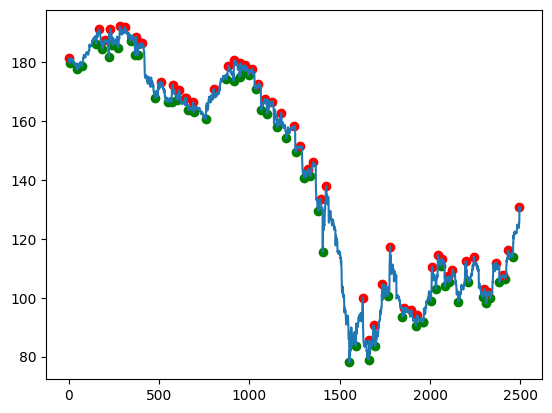

In [ ]:
plt.scatter(range(len(df)),df['min'], c='g')
plt.scatter(range(len(df)),df['max'], c='r')
plt.plot(range(len(df)),df['Close'])
plt.show()

**CORRELATION STARTS FROM HERE**

**COMPARING BUY/SELL/HOLD SIGNALS DOESN'T MAKE MUCH SENSE, SINCE THEY ARE SPARSE,AND THE LAG OF INDICATOR SIGNALS WITH TRUE SIGNALS IS UNEVEN AT EACH POINT OF INFLECTION,**

**Instead, a good way to compare two trade signals would be compare persisting positions, if we buy, the signal is 1 consecutively(buy position) unless sell is encountered and vice versa**

**We can move ahead with the number of common matches (between true signal and indicator signal) in position**

In [ ]:
signals = [col for col in df.columns if 'signal' in col]

for signal in signals:
    for day in np.unique(df.index.date):
        indices = df[df.index.date == day].index
        for i in range(len(indices) - 1):  # subtracting 1 because we're looking ahead by 1 row
            if df.loc[indices[i], signal] == 1 and df.loc[indices[i + 1], signal] == 0:
                df.loc[indices[i + 1], signal] = 1
            elif df.loc[indices[i], signal] == -1 and df.loc[indices[i + 1], signal] == 0:
                df.loc[indices[i + 1], signal] = -1


the metrics for the same would be-
accuracy,
precision,
recall and
f1_score.
This will allow me to generate a confusion matrix also


 I do not see a good reason to not consider this way of comparing two discrete position signals


In [ ]:
df['ema_signal'][:39] #cheking if the signals seem alright (inclusing the last period of the day having 38 periods)


Date
2020-01-21 09:15:00    0
2020-01-21 09:25:00    1
2020-01-21 09:35:00    1
2020-01-21 09:45:00    1
2020-01-21 09:55:00    1
2020-01-21 10:05:00    1
2020-01-21 10:15:00    1
2020-01-21 10:25:00    1
2020-01-21 10:35:00    1
2020-01-21 10:45:00    1
2020-01-21 10:55:00    1
2020-01-21 11:05:00    1
2020-01-21 11:15:00    1
2020-01-21 11:25:00    1
2020-01-21 11:35:00    1
2020-01-21 11:45:00    1
2020-01-21 11:55:00    1
2020-01-21 12:05:00    1
2020-01-21 12:15:00    1
2020-01-21 12:25:00    1
2020-01-21 12:35:00    1
2020-01-21 12:45:00    1
2020-01-21 12:55:00    1
2020-01-21 13:05:00    1
2020-01-21 13:15:00    1
2020-01-21 13:25:00    1
2020-01-21 13:35:00    1
2020-01-21 13:45:00    1
2020-01-21 13:55:00    1
2020-01-21 14:05:00    1
2020-01-21 14:15:00    1
2020-01-21 14:25:00    1
2020-01-21 14:35:00    1
2020-01-21 14:45:00    1
2020-01-21 14:55:00    1
2020-01-21 15:05:00    1
2020-01-21 15:15:00    1
2020-01-21 15:25:00   -1
2020-01-22 09:15:00    0
Name: ema_signal, dt

**Comparing each indicator signal with True signal and correlating using accuracy, precision, recall and f1 score**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize a dictionary to hold the results
results = {}

# Looping over each indicator signal
for signal in signals:
    # Calculating  metrics
    accuracy = accuracy_score(df['true_signal'], df[signal])
    precision = precision_score(df['true_signal'], df[signal], average='weighted', zero_division=0)
    recall = recall_score(df['true_signal'], df[signal], average='weighted', zero_division=0)
    f1 = f1_score(df['true_signal'], df[signal], average='weighted', zero_division=0)

    # Store the results
    results[signal] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Converting  results to dataframe
results_df = pd.DataFrame(results).transpose()

print(results_df)


                      accuracy  precision    recall  f1_score
true_signal           1.000000   1.000000  1.000000  1.000000
sma_signal            0.404886   0.512345  0.404886  0.331120
sma_crossover_signal  0.399279   0.424399  0.399279  0.310284
ema_signal            0.340809   0.434414  0.340809  0.302755
ema_crossover_signal  0.399279   0.465457  0.399279  0.335897
rsi_signal            0.412095   0.554582  0.412095  0.264743
bb_signal             0.388867   0.151217  0.388867  0.217756
adx_signal            0.349219   0.390093  0.349219  0.330273


**Generating report for correlating positions , but using a lag of -5 to +5 for each indicator**

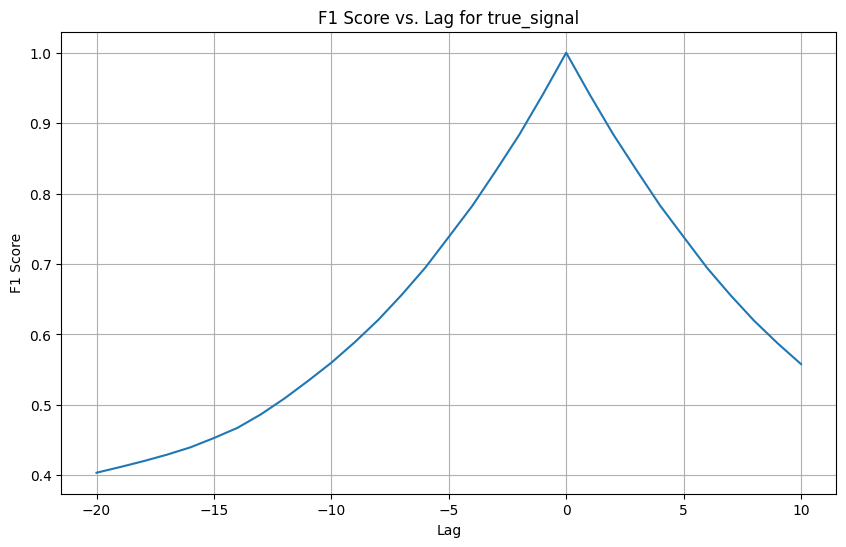

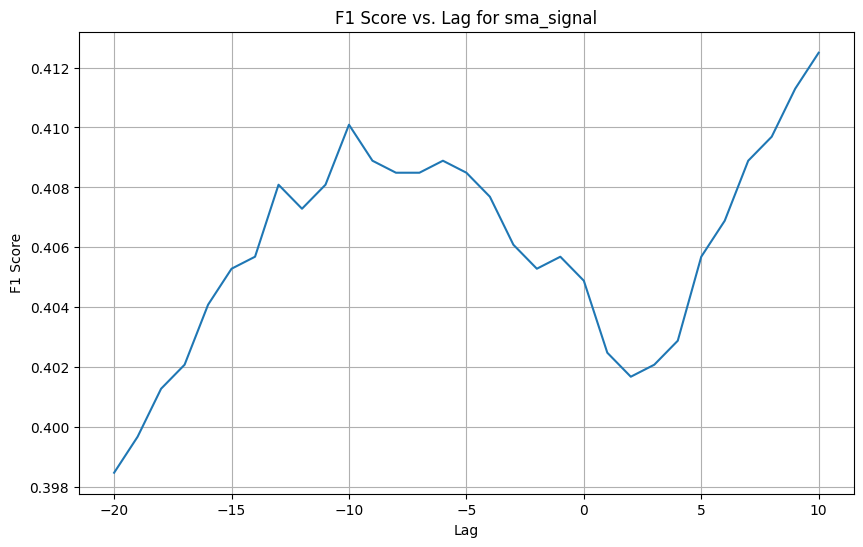

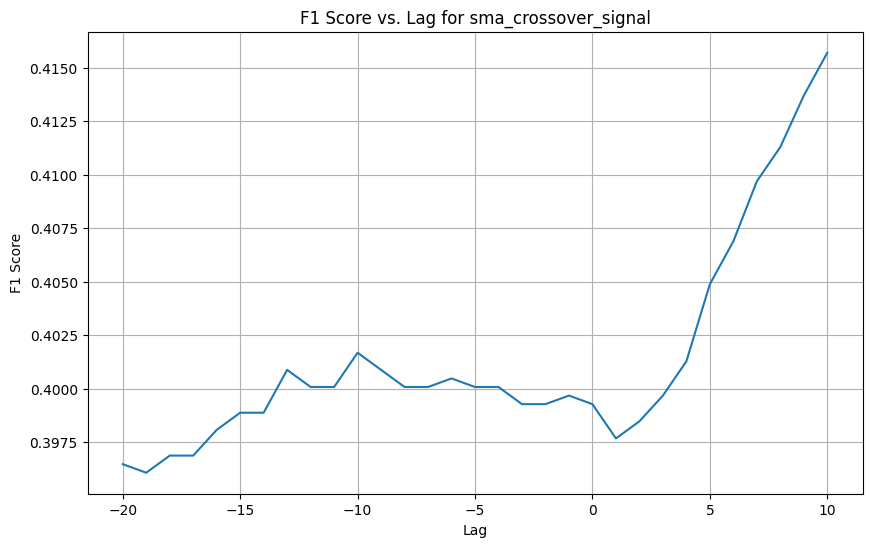

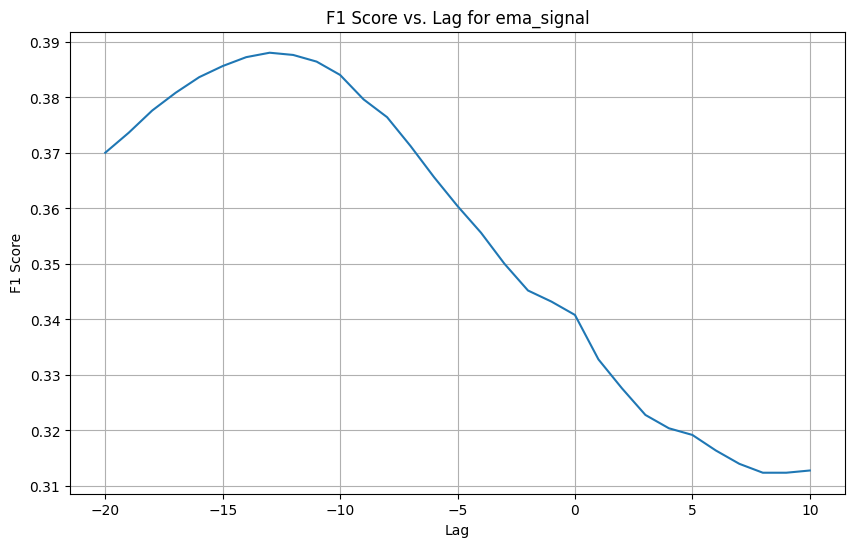

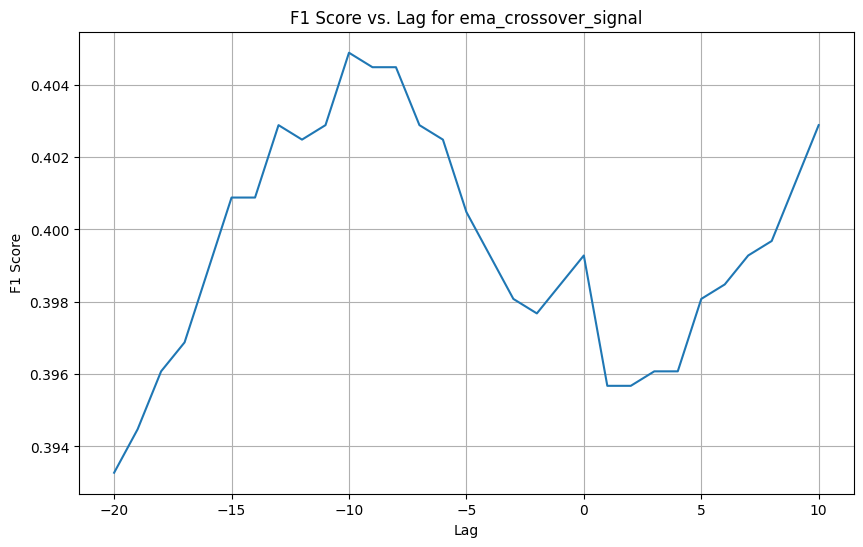

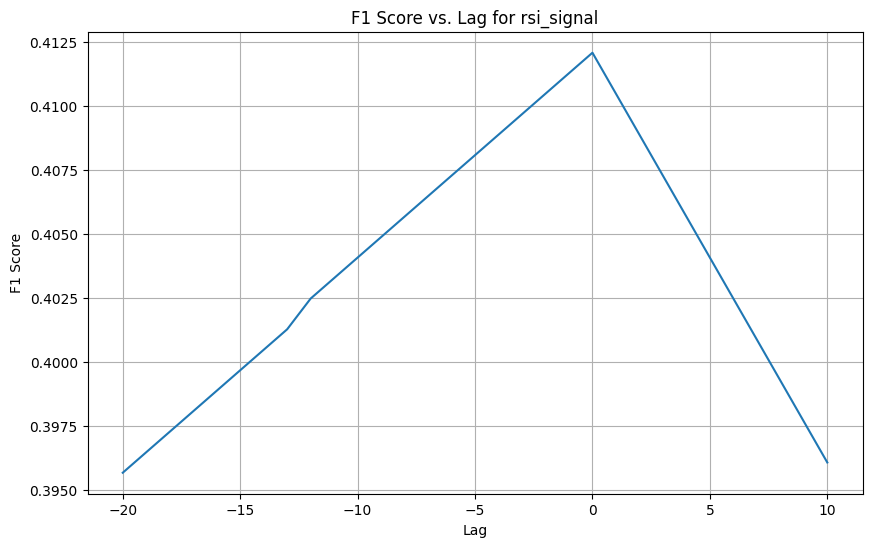

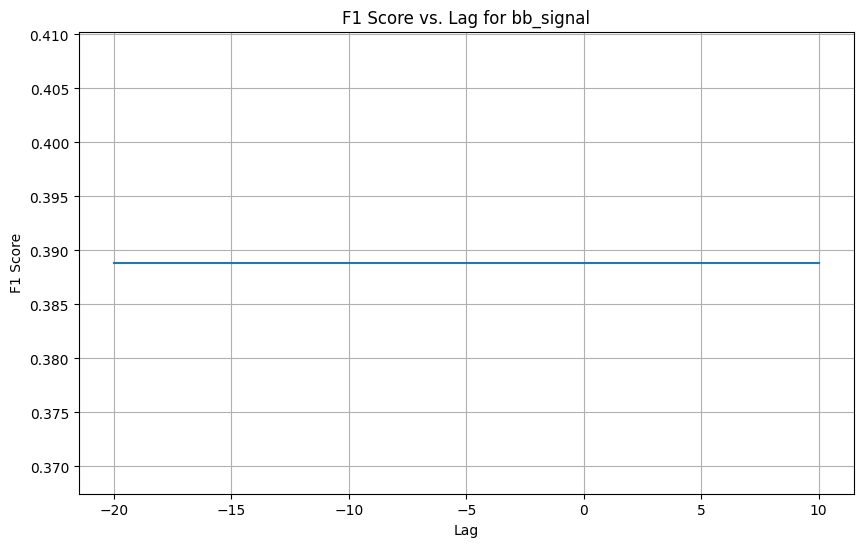

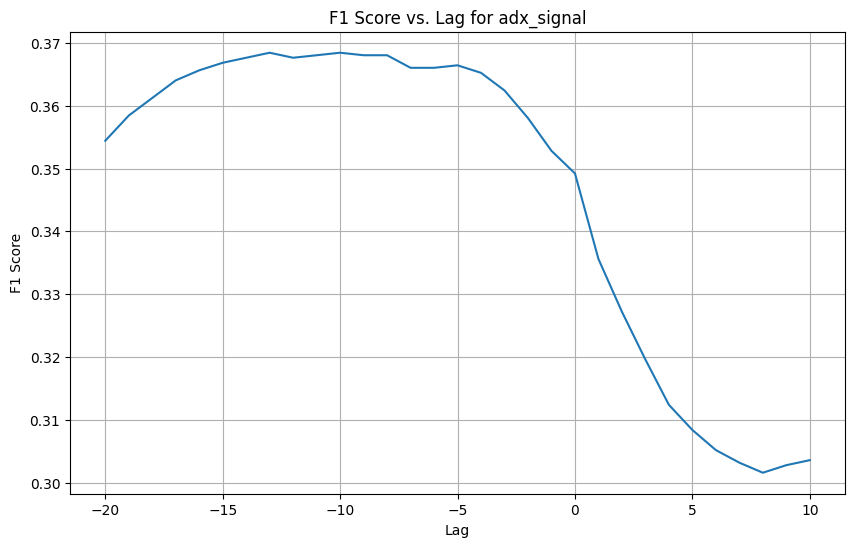

accuracy  precision    recall  f1_score
sma_signal -20  0.398478   0.398478  0.398478  0.398478
           -19  0.399680   0.399680  0.399680  0.399680
           -18  0.401282   0.401282  0.401282  0.401282
           -17  0.402082   0.402082  0.402082  0.402082
           -16  0.404085   0.404085  0.404085  0.404085
...                  ...        ...       ...       ...
adx_signal  6   0.305166   0.305166  0.305166  0.305166
            7   0.303164   0.303164  0.303164  0.303164
            8   0.301562   0.301562  0.301562  0.301562
            9   0.302763   0.302763  0.302763  0.302763
            10  0.303564   0.303564  0.303564  0.303564

[217 rows x 4 columns]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = {}

for signal in signals:
    f1_scores = []
    lags = list(range(-20, 11))
    for lag in lags:
        # Shifting the signal using the lag value
        shifted_signal = df[signal].shift(lag).fillna(0)

        # Calculating metrics
        accuracy = accuracy_score(df['true_signal'], shifted_signal)
        precision = precision_score(df['true_signal'], shifted_signal, average='micro', zero_division=0)
        recall = recall_score(df['true_signal'], shifted_signal, average='micro', zero_division=0)
        f1 = f1_score(df['true_signal'], shifted_signal, average='micro', zero_division=0)

        # Store the results
        results[(signal, lag)] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

        # Store the F1 score for the plot
        f1_scores.append(f1)

    # Plot F1 score vs. lag for the current signal
    plt.figure(figsize=(10, 6))
    plt.plot(lags, f1_scores)
    plt.xlabel('Lag')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score vs. Lag for {signal}')
    plt.grid(True)
    plt.show()

# Converting results to dataframe
results_df = pd.DataFrame(results).transpose()

results_df.drop(index="true_signal", inplace=True)
results_df


**we can also use Cohen's Kappa.Let's analyse and see what we obtain here**

In [ ]:
from sklearn.metrics import cohen_kappa_score

# Initialize a dictionary to hold the results
kappa_results = {}

# Loop over each signal
for signal in signals:
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(df['true_signal'], df[signal])

    # Store the results
    kappa_results[signal] = kappa

# Convert the results to a DataFrame for easier viewing
kappa_results_df = pd.DataFrame(list(kappa_results.items()), columns=['Signal', 'Cohen\'s Kappa'])

print(kappa_results_df)


                 Signal  Cohen's Kappa
0           true_signal       1.000000
1            sma_signal       0.071753
2  sma_crossover_signal       0.060579
3            ema_signal       0.013921
4  ema_crossover_signal       0.084152
5            rsi_signal       0.042527
6             bb_signal       0.000000
7            adx_signal       0.008879


Looking at the Cohen's Kappa scores, it appears that none of the signals strongly agree with the true signal. The highest Cohen's Kappa score, excluding the true signal itself, is for the `ema_crossover_signal` at approximately 0.084. This suggests a slight agreement, but it's far from a strong agreement.

Given these results, I feel that using these signals in their current form to predict the true signal might not yield the best results. The low Cohen's Kappa scores indicate that the agreement between each signal and the true signal is not much better than what would be expected by chance.


**Calculating Cohen's kappa with a lag of -5 to +5**

In [ ]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Initialize a dictionary to hold the results
kappa_results = {}

# Loop over each signal
for signal in signals:
    for lag in range(-5, 6):
        # Shift the signal data by the lag
        shifted_signal = df[signal].shift(lag)

        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(df['true_signal'].iloc[5:-5], shifted_signal.iloc[5:-5])

        # Store the results
        kappa_results[(signal, lag)] = kappa

# Convert the results to a DataFrame for easier viewing
kappa_results_df = pd.DataFrame(list(kappa_results.items()), columns=['Signal and Lag', 'Cohen\'s Kappa'])
kappa_results_df

,Signal and Lag,Cohen's Kappa
0,"(true_signal, -5)",0.607257
1,"(true_signal, -4)",0.674748
2,"(true_signal, -3)",0.750139
3,"(true_signal, -2)",0.826749
4,"(true_signal, -1)",0.911250
...,...,...
83,"(adx_signal, 1)",-0.011676
84,"(adx_signal, 2)",-0.024599
85,"(adx_signal, 3)",-0.036300
86,"(adx_signal, 4)",-0.047388


**Plotting the lag vs cohen's kappa for each indicator**

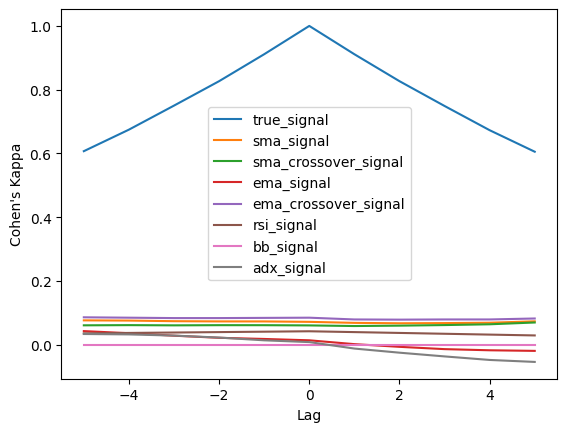

In [ ]:
import matplotlib.pyplot as plt

# Separate the 'Signal and Lag' column into two separate columns
kappa_results_df[['Signal', 'Lag']] = pd.DataFrame(kappa_results_df['Signal and Lag'].tolist(), index=kappa_results_df.index)

# Loop over each unique signal
for signal in kappa_results_df['Signal'].unique():
    # Filter the DataFrame for the current signal
    df_signal = kappa_results_df[kappa_results_df['Signal'] == signal]

    # Plot the lag vs Cohen's Kappa
    plt.plot(df_signal['Lag'], df_signal['Cohen\'s Kappa'], label=signal)

# Add labels and a legend
plt.xlabel('Lag')
plt.ylabel('Cohen\'s Kappa')
plt.legend()

# Show the plot
plt.show()


Basically Cohen's kappa for a lag of -5 to 5 is very low for all the  indicators, hence not a conclusive metric for correlation

# **Regression Analysis**
we have already compared discrete signals with discrete signals, let's compare discrete signal(true inflection signal) with continuous signal(indicator values), and do a regression analysis on them


In [ ]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.7 MB/s eta 0:00:00


# Metrics Explanation



## Spearman Correlation
Spearman correlation measures the monotonic relationship between two datasets. Like Pearson correlation, its value ranges from -1 to 1.
- **-1**: Perfect negative monotonic relationship
- **0**: No monotonic relationship
- **1**: Perfect positive monotonic relationship
High absolute values (close to -1 or 1) indicate a strong monotonic relationship, while values close to 0 indicate a weak monotonic relationship.



## Dynamic Time Warping (DTW)
DTW is a measure of similarity between two temporal sequences, which may vary in speed. It's often used in time series classification. Lower values indicate that the sequences are more similar.


## Mutual Information
Mutual Information (MI) is a measure of the mutual dependence between two variables. It quantifies the "amount of information" obtained about one random variable by observing the other random variable. The concept of mutual information is intimately linked to that of entropy of a random variable, a fundamental notion in information theory that quantifies the expected "amount of information" held in a random variable.

MI is not limited to real-valued random variables and linear dependence like the correlation coefficient. It is more general and determines how different the joint distribution of the pair (X, Y) is from the product of the marginal distributions of X and Y. MI is the expected value of the pointwise mutual information (PMI).

In terms of probability mass functions (PMFs) for discrete distributions, the mutual information of two jointly discrete random variables X and Y is calculated as:

$$ MI(X;Y) = \sum_{x \in X} \sum_{y \in Y} p(x,y) \log \left( \frac{p(x,y)}{p(x)p(y)} \right) $$

where:
- $p(x,y)$ is the joint probability mass function of X and Y,
- $p(x)$ and $p(y)$ are the marginal probability mass functions of X and Y respectively.

MI is also used in determining the similarity of two different clusterings of a dataset. As such, it provides some advantages over the traditional Rand index. Mutual information of words is often used as a significance function for the computation of collocations in corpus linguistics.

Please note that MI is non-negative and it is equal to zero precisely when X and Y are independent (and hence observing X tells you nothing about Y). If the natural logarithm is used, the unit of mutual information is the nat. If the log base 2 is used, the unit of mutual information is the shannon, also known as the bit.





In [ ]:
!pip install dtaidistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.0 MB/s eta 0:00:00


In [ ]:
from scipy.stats import spearmanr
from scipy.spatial.distance import euclidean
import numpy as np
from dtaidistance import dtw
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

results = {}

df = df.fillna(0)
df['sma_diff'] = df['sma_short'] - df['sma_long']
df['ema_diff'] = df['ema_short'] - df['ema_long']
df['sma_close_diff'] = df['sma'] - df['Close']
df['ema_close_diff'] = df['ema'] - df['Close']

# List of signal columns to compare with the ground truth
signal_columns = ['sma', 'sma_diff', 'sma_close_diff', 'ema', 'ema_diff', 'ema_close_diff', 'rsi', 'adx']

# Ground truth series
ground_truth = df['true_signal']
print(f"Shape of ground truth: {ground_truth.shape}")

batch_size = 38  # 38 because there are 38 periods in the day trading data

for column in signal_columns:
    # Signal series
    signal = df[column]

    # Initialize lists to store batch-wise metrics for each column
    spearman_corrs = []
    dtw_dists = []
    mutual_infos = []

    # Number of batches
    num_batches = len(signal) // batch_size

    for i in range(num_batches):
        # Get the batch of data
        batch_signal = signal[i*batch_size:(i+1)*batch_size]
        batch_ground_truth = ground_truth[i*batch_size:(i+1)*batch_size]

        # Check for variation in the data
        if np.std(batch_signal) == 0 or np.std(batch_ground_truth) == 0:
            continue

        # Spearman correlation
        spearman_corr = spearmanr(batch_signal, batch_ground_truth)[0]
        spearman_corrs.append(spearman_corr)

        # Dynamic Time Warping
        dtw_dist = dtw.distance(batch_signal, batch_ground_truth)
        dtw_dists.append(dtw_dist)

        # Mutual Information
        mutual_info = mutual_info_score(batch_signal, batch_ground_truth)
        mutual_infos.append(mutual_info)

    # Store the results
    results[column] = [np.mean(spearman_corrs), np.mean(dtw_dists), np.mean(mutual_infos)]

# Print the results for each indicator
for column, metrics in results.items():
    print(f"Results for {column}:")
    print(f"Mean Spearman correlation: {metrics[0]}")
    print(f"Mean DTW distance: {metrics[1]}")
    print(f"Mean mutual information: {metrics[2]}\n")


Shape of ground truth: (2497,)
Results for sma:
Mean Spearman correlation: -0.3514899860215869
Mean DTW distance: 863.0786499838886
Mean mutual information: 0.6628169628032777

Results for sma_diff:
Mean Spearman correlation: -0.38450249389109264
Mean DTW distance: 299.0692336751271
Mean mutual information: 0.6995438662451131

Results for sma_close_diff:
Mean Spearman correlation: -0.1354675969507794
Mean DTW distance: 7.711471040290413
Mean mutual information: 0.5674290910726223

Results for ema:
Mean Spearman correlation: -0.1398238465777498
Mean DTW distance: 867.3935646851062
Mean mutual information: 0.7034872267761049

Results for ema_diff:
Mean Spearman correlation: -0.38391378972884904
Mean DTW distance: 55.477885349027474
Mean mutual information: 0.7034872267761049

Results for ema_close_diff:
Mean Spearman correlation: 0.23444358665320666
Mean DTW distance: 18.945991094823523
Mean mutual information: 0.7034872267761049

Results for rsi:
Mean Spearman correlation: -0.1986105690

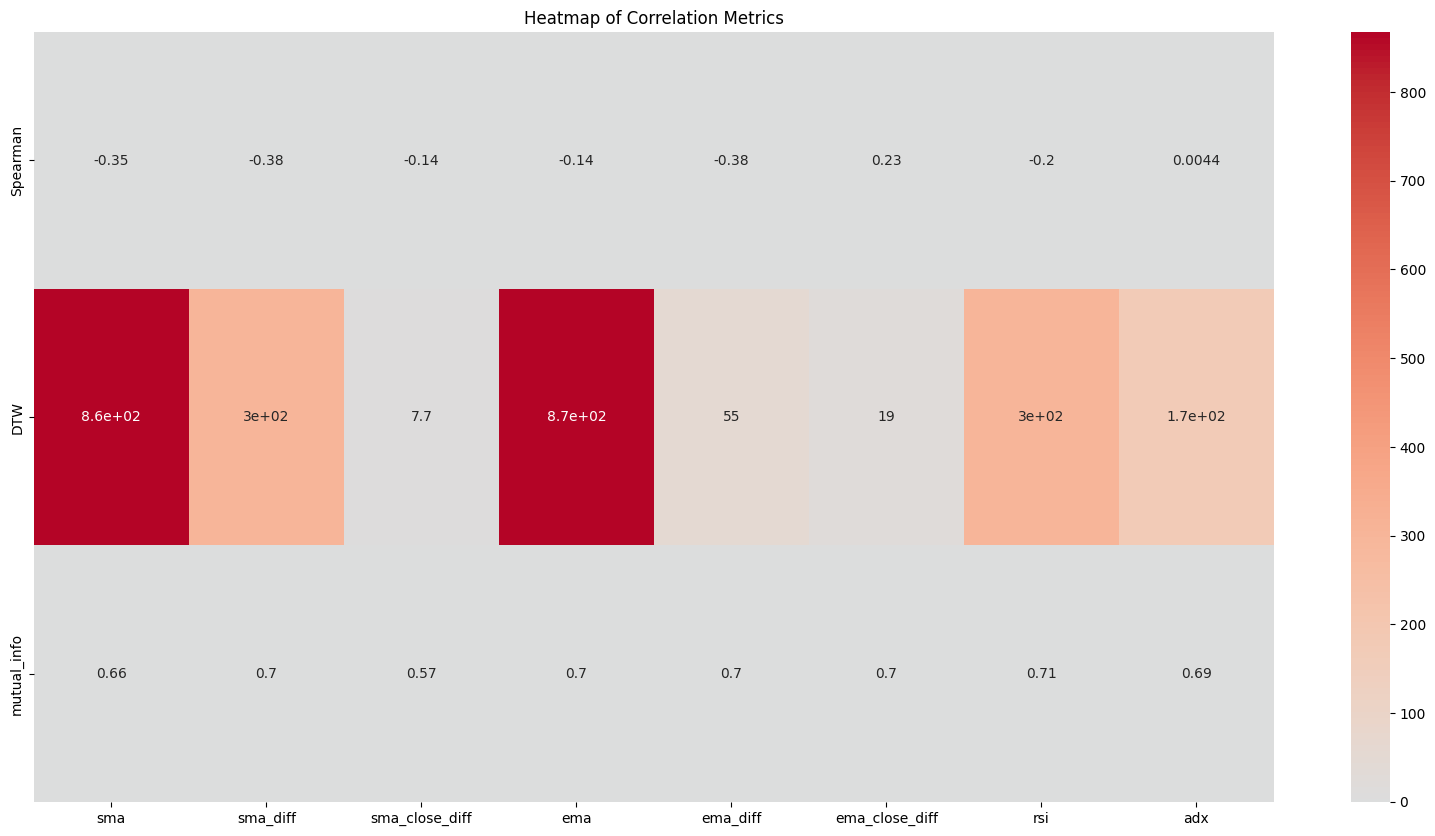

In [ ]:
# Convert the results to a DataFrame
df_results = pd.DataFrame(results, index=['Spearman',  'DTW',"mutual_info"])

# Plot a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(df_results, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Correlation Metrics')
plt.show()

In [ ]:
df_results

,sma,sma_diff,sma_close_diff,ema,ema_diff,ema_close_diff,rsi,adx
Spearman,-0.351490,-0.384502,-0.135468,-0.139824,-0.383914,0.234444,-0.198611,0.004404
DTW,863.078650,299.069234,7.711471,867.393565,55.477885,18.945991,298.598578,173.052875
mutual_info,0.662817,0.699544,0.567429,0.703487,0.703487,0.703487,0.709202,0.693857


Based on my analysis of the provided metrics, I observe that the indicators ‘sma_diff’, ‘ema_diff’, and ‘rsi’ demonstrate the most promising results:

Spearman Correlation: ‘sma_diff’ and ‘ema_diff’ exhibit the highest absolute Spearman correlation values, suggesting strong monotonic relationships with the target variable.

Dynamic Time Warping (DTW): ‘sma_close_diff’ and ‘ema_close_diff’ have the lowest DTW distances, indicating a close alignment with the target variable over time.

Mutual Information: ‘sma_diff’, ‘ema_diff’, and ‘rsi’ have high mutual information values, implying a substantial amount of shared information with the target variable.

**COINTEGRATION**

The next code block is designed to perform a cointegration test on multiple trading indicators.

Cointegration is a statistical property of time series variables. If two or more series are individually non-stationary (i.e., they tend to wander away over time), but a linear combination of them is stationary, then the series are said to be cointegrated.

In the context of trading, if the price series of two assets are cointegrated, it means they move together over time. When they diverge significantly, it's likely they'll revert back, which can be used to inform trading strategies.

The `signal_columns` list contains the names of the signal columns in the DataFrame `df`. For each signal column, the code performs a cointegration test with the `signal` column using the `coint` function from the `statsmodels` library.

The `coint` function returns three values: the t-statistic of unit-root test on residuals, the p-value of the test, and the critical values for the test statistic at the 1%, 5%, and 10% levels.

The p-value is used to determine the significance of the results. A common threshold for significance is 0.05:
- **p <= 0.05**: The series are likely cointegrated (Reject the null hypothesis)
- **p > 0.05**: The series are not likely cointegrated (Fail to reject the null hypothesis)

This analysis can help in identifying pairs of indicators that move together, which can be useful in pair trading strategies.

However, "moving together" is also inflated , since there are a lot of 0s(holding positions) moving together when comparing two columns. So again, I advise to take this report with a pinch of salt


In [ ]:
import statsmodels.api as sm
signal_columns = ['sma_signal', 'sma_crossover_signal', 'ema_signal', 'ema_crossover_signal', 'rsi_signal', 'bb_signal', 'adx_signal']

report = pd.DataFrame(columns=['Signal Column', 'p-value'])

# Loop over the signal columns
for signal_column in signal_columns:
    # Perform the cointegration test
    coint_t, p_value, crit_value = sm.tsa.stattools.coint(df['true_signal'], df[signal_column])

    report = report.append({'Signal Column': signal_column, 'p-value': p_value}, ignore_index=True)

# Print the report
print(report)


          Signal Column       p-value
0            sma_signal  1.190689e-20
1  sma_crossover_signal  1.013917e-20
2            ema_signal  1.273699e-20
3  ema_crossover_signal  1.065742e-20
4            rsi_signal  7.363728e-21
5             bb_signal  1.388461e-20
6            adx_signal  2.312426e-20


So smaller values of cointegration suggest rejecting the null hypothesis - basically concluding that  a significant long-term equilibrium relationship between various trading signals and the target variable. Despite short-term fluctuations, these signals are expected to converge over time. Again, this is a long term correlation, not a short term

# **Report Obtained for each Indicator**
**The reports include these:**

(i)  Indicator

(ii) Best Window sizes(small +big)

(iii) Hit Rate/Win rate

(iv) Profit Factor

(v) Sharpe Ratio

(vi) Max Drawdown

(vii) Total profit

(viii) Profit Percentage

(ix) Average Win to Average Loss Ratio

(x) Sortino Ratio

(xi) Number of Trades

In [ ]:
metrics_df=metrics_df.drop(["indicator","hit_rate","profit_factor","sharpe_ratio","max_drawdown","total_profit"	,"profit_percentage","avg_win_to_avg_loss_ratio","sortino_ratio","num_trades"],axis=1)
metrics_df

,Indicator,Best_n,Best_m,Hit_Rate,Profit_Factor,Sharpe_Ratio,Max_Drawdown,Total_Profit,Profit_Percentage,Avg_Win_to_Avg_Loss_Ratio,Sortino_Ratio,Num_Trades
0,Local Extrema,16.0,None,0.560606,36.639919,0.499122,-100.8,6328.697400,63.286974,5.941608,2.476497,43.0
1,SMA,524.0,None,0.181818,1.975683,0.145539,-411.4,1430.087400,14.300874,1.481762,0.203369,21.0
2,SMA_Crossover,564.0,4,0.166667,2.370887,0.167241,-384.8,1612.681500,16.126815,-1.724281,0.258085,19.0
3,EMA,63.0,None,0.333333,2.521841,0.210170,-458.8,3291.444203,32.914442,2.245777,0.499969,46.0
4,EMA_Crossover,374.0,5,0.227273,1.466662,0.096020,-458.8,588.591170,5.885912,-1.564439,0.140211,31.0
5,RSI,118.0,None,0.030303,-inf,0.168908,0.0,1939.418850,19.394189,NaN,NaN,2.0
6,Bollinger Bands,2.0,None,0.000000,NaN,NaN,0.0,0.000000,0.000000,NaN,NaN,0.0
7,ADX,32.0,None,0.318182,2.324768,0.193936,-572.0,2773.550910,27.735509,-2.075775,0.331455,46.0


In [ ]:
pd.__version__

# **Plots and Vizualizations for selective Indicators**

In [ ]:
df2=df.copy()
df2.reset_index(level=0, inplace=True)
df2.rename(columns={'index': 'Date'}, inplace=True)
df2['Date'] = pd.to_datetime(df2['Date'])
# callable plotting function

def plot_df(columns, date_range):
    if columns:  # Check if any column is selected
        fig, ax = plt.subplots(figsize=(50, 20))  # Create a figure and a set of subplots
        df2.set_index('Date').loc[date_range[0]:date_range[1], list(columns)].plot(ax=ax)  # Plot on the specific axes
        ax.grid(True)
        ax.legend(fontsize="40")  # Increase the legend size

        font = {'weight' : 'bold',
                'size'   : 22}

        plt.rc('font', **font)
        plt.show()

# Getting column names from the dfFrame
column_names = [col for col in df2.columns.tolist() if col != 'Date']

# Here creating date range slider
dates = pd.date_range(df2['Date'].min(), df2['Date'].max(), freq='D')
options = [(date.strftime(' %d %b %Y '), date) for date in dates]
date_range_slider = SelectionRangeSlider(
    options=options,
    index=(0, len(options)-1),
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)


# Plotting interactive plot
interact(plot_df, columns=SelectMultiple(options=column_names), date_range=date_range_slider)

interactive(children=(SelectMultiple(description='columns', options=('Open', 'High', 'Low', 'Close', 'Volume',…

<function __main__.plot_df(columns, date_range)>